In [3]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
import os.path

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

In [5]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [95]:
def make_switching_world(rlow, rhigh, nblocks, ntrialsLow, ntrialsHigh):
    ratesL = (np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    ratesR = (1 - np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    if np.random.rand() > 0.5:
        rates = np.vstack((ratesL, ratesR)).T
    else:
        rates = np.vstack((ratesR, ratesL)).T
    ntrials = np.random.uniform(low=ntrialsLow, high=ntrialsHigh, size=nblocks).astype('int')
    world = PersistentWorld(rates=rates, ntrials=ntrials)
    return world

def make_switching_world_withCheck(rlow, rhigh, nblocks, ntrialsLow, ntrialsHigh):
    ratesL = (np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    ratesR = (1 - np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    if np.random.rand() > 0.5:
        rates = np.vstack((ratesL, ratesR)).T
    else:
        rates = np.vstack((ratesR, ratesL)).T
    ntrials = np.random.uniform(low=ntrialsLow, high=ntrialsHigh, size=nblocks).astype('int')
    world = PersistentWorldWithCheck(rates=rates, ntrials=ntrials, threshold=0.8)
    return world

def errorsigmoid(p, x, y):
    '''
    Error function used for sigmoid fitting
    '''
    try:
        preds = 1 / (1 + np.exp(-p[0] * (x + p[1])))
        res = np.sum((preds - y)**2)
    except RuntimeWarning:
        print('Overflow!')
    return np.sum((preds - y)**2)

In [317]:
def find_LR_transition_fit(world, agent, window):
    '''
    For a switching world, determines the agent transition functions,
    for left->right and right->left transitions
    window: how many trials after the transition do we want to keep for fitting?
    '''
    # Find where the block transitions happen
    side_history = np.array(world.rate_history)[:,0]
    blocktrans = np.where(np.diff(side_history) != 0)[0][:-1]

    # Get the choices around the transition
    choicelst = []
    for i in range(window):
        choicelst.append(np.array(agent.choice_history)[blocktrans + i])

    choicelst = np.array(choicelst)

    #print('choicemean = ', np.mean(choicelst[:,::2]), 'side=  ', world.side_history[0][0])
    pRight, pLeft = fit_sigmoidal(choicelst, first_side=world.side_history[0][0])
    return (pRight, pLeft)
    
    
    
def find_transition_guess(sig):
    '''
    Returns the offset where a time series crosses 0.5
    '''
    return np.argmin((sig-0.5)**2) 

def find_transition_guess_binary(sig):
    '''
    Returns the offset where a time series crosses 0.5, through binary segmentation
    '''
    return np.where(np.diff(sig > 0.5) != 0)[0][0]


def fit_sigmoidal(choicelst, first_side):
    '''
    Fit a sigmoidal to the average choice data
    first_side: first side that is rewarded, i.e. world.side_history[0][0]
    '''
    #print('choicemean = ', np.mean(choicelst[:,::2]), 'side=  ', first_side)
    if first_side == 0:
        #print('left')
        leftAverage = np.mean(choicelst[:,::2], axis=1)
        rightAverage = np.mean(choicelst[:,1::2], axis=1)
    else:
        #print('right')
        rightAverage = np.mean(choicelst[:,::2], axis=1)
        leftAverage = np.mean(choicelst[:,1::2], axis=1)

    offsets = np.arange(len(leftAverage))

    # Fit right transitions
    funR = lambda x: errorsigmoid(x, offsets, rightAverage)
    switchGuessR = find_transition_guess_binary(rightAverage) #offset that crosses 0.5
    paramsRight = scipy.optimize.minimize(funR, [1,-switchGuessR])
    pRight = paramsRight.x
    
    funL = lambda x: errorsigmoid(x, offsets, leftAverage)
    switchGuessL = find_transition_guess_binary(leftAverage)
    paramsLeft = scipy.optimize.minimize(funL, [-1,-switchGuessL])
    pLeft = paramsLeft.x
    
    return pRight, pLeft

In [325]:
np.random.seed(0)
pswitchlst = np.linspace(0.01, 0.45, 15)
prewlst = np.linspace(0.55, 0.99, 10)

N_iters = 50
num_states = 2
obs_dim = 1
rlow = 0
rhigh = 1
nblocks = 100
eps = 0
ntrials_per_block = [15, 25]

T11lst = np.zeros((len(pswitchlst), len(prewlst)))
T22lst = np.zeros((len(pswitchlst), len(prewlst)))
E1lst = np.zeros((len(pswitchlst), len(prewlst)))
E2lst = np.zeros((len(pswitchlst), len(prewlst)))
efflist = np.zeros((len(pswitchlst), len(prewlst)))
PRslopelist = np.zeros((len(pswitchlst), len(prewlst)))
PLslopelist = np.zeros((len(pswitchlst), len(prewlst)))
PRoffsetlist = np.zeros((len(pswitchlst), len(prewlst)))
PLoffsetlist = np.zeros((len(pswitchlst), len(prewlst)))

for seed in [9]:
    print(seed)
    np.random.seed(seed)
    for idsw, psw in enumerate(pswitchlst):
        print('* pswitch = ', psw)
        for idrew, prew in enumerate(prewlst):
            print('     prew = ', prew)
            world = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
            agent = EGreedyInferenceBasedAgent(prew=prew, pswitch=psw, eps=eps)
            exp = Experiment(agent, world)
            exp.run()  

            # Fit HMM to choice sequence
            data = np.array(agent.choice_history)[:,None] 

            ## testing the constrained transitions class
            hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
            hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)

            # Sigmoidal fit for choice transitions
            pR, pL = find_LR_transition_fit(world, agent, window=15)

            efflist[idsw][idrew] = agent.find_efficiency()
            T11lst[idsw][idrew] = hmm.transitions.transition_matrix[0][0]
            T22lst[idsw][idrew] = hmm.transitions.transition_matrix[1][1]
            E1lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[0]
            E2lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[1]
            PRslopelist[idsw][idrew] = pR[0]
            PLslopelist[idsw][idrew] = pL[0]
            PRoffsetlist[idsw][idrew] = pR[1]
            PLoffsetlist[idsw][idrew] = pL[1]
        
        
    
                  

9
* pswitch =  0.01
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.04142857142857143
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.07285714285714286
     prew =  0.55
     prew =  0.5988888888888889
     prew =  0.6477777777777778
     prew =  0.6966666666666668
     prew =  0.7455555555555555
     prew =  0.7944444444444445
     prew =  0.8433333333333334
     prew =  0.8922222222222222
     prew =  0.9411111111111111
     prew =  0.99
* pswitch =  0.10428571428571429
     

In [290]:
pR, pL = find_LR_transition_fit(world, agent, window=15)

In [291]:
pL

array([ 7.78741720e-05, -1.47980733e+04])

In [292]:
# Find where the block transitions happen
window = 15
side_history = np.array(world.rate_history)[:,0]
blocktrans = np.where(np.diff(side_history) != 0)[0][:-1]

# Get the choices around the transition
choicelst = []
for i in range(window):
    choicelst.append(np.array(agent.choice_history)[blocktrans + i])

choicelst = np.array(choicelst)

In [297]:
fit_sigmoidal(choicelst, first_side=world.side_history[0][0])

(array([ 4.56698865, -2.47327016]), array([ 7.78741720e-05, -1.47980733e+04]))

In [298]:
world.side_history[0][0]

True

In [304]:
first_side=1
if first_side == 0:
    #print('left')
    leftAverage = np.mean(choicelst[:,::2], axis=1)
    rightAverage = np.mean(choicelst[:,1::2], axis=1)
else:
    #print('right')
    rightAverage = np.mean(choicelst[:,::2], axis=1)
    leftAverage = np.mean(choicelst[:,1::2], axis=1)

offsets = np.arange(len(leftAverage))

# Fit right transitions
funR = lambda x: errorsigmoid(x, offsets, rightAverage)
switchGuessR = np.argmin((rightAverage-0.5)**2) #offset that crosses 0.5
paramsRight = scipy.optimize.minimize(funR, [1,-switchGuessR])
pRight = paramsRight.x

funL = lambda x: errorsigmoid(x, offsets, leftAverage)
switchGuessL = np.argmin((leftAverage-0.5)**2) #offset that crosses 0.5
paramsLeft = scipy.optimize.minimize(funL, [1,-3])
pLeft = paramsLeft.x

In [315]:
np.where(np.diff(rightAverage > 0.5) > 0)[0][0]

2

In [305]:
x = np.linspace(0,15,100)
preds = 1 / (1 + np.exp(-pLeft[0] * (x + pLeft[1])))

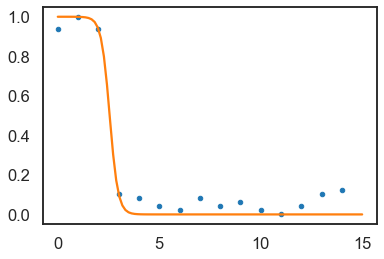

In [306]:
plt.plot(leftAverage, '.')
plt.plot(x,preds)

In [114]:
# Save results
filename = 'EGreedyInferenceBasedAgent-prob0to1.mat'
if not os.path.exists(filename):
    scipy.io.savemat('EGreedyInferenceBasedAgent-prob0to1.mat', {'pswitchlst': pswitchlst,
                    'prewlst': prewlst, 'N_iters': N_iters, 'num_states': num_states,
                    'obs_dim': obs_dim, 'rlow': rlow, 'rhigh': rhigh, 'eps': eps,
                    'ntrials_per_block': ntrials_per_block, 'T11lst': T11lst, 'T22lst': T22lst,
                    'E1lst': E1lst, 'E2lst': E2lst, 'efflist': efflist, 'PRslopelist': PRslopelist,
                    'PRoffsetlist': PRoffsetlist, 'PLslopelist': PLslopelist, 'PLoffsetlist': PLoffsetlist})
else:
    print('File exists! Skipping save...')

File exists! Skipping save...


Text(0.5, 1.0, 'Action probability (right)')

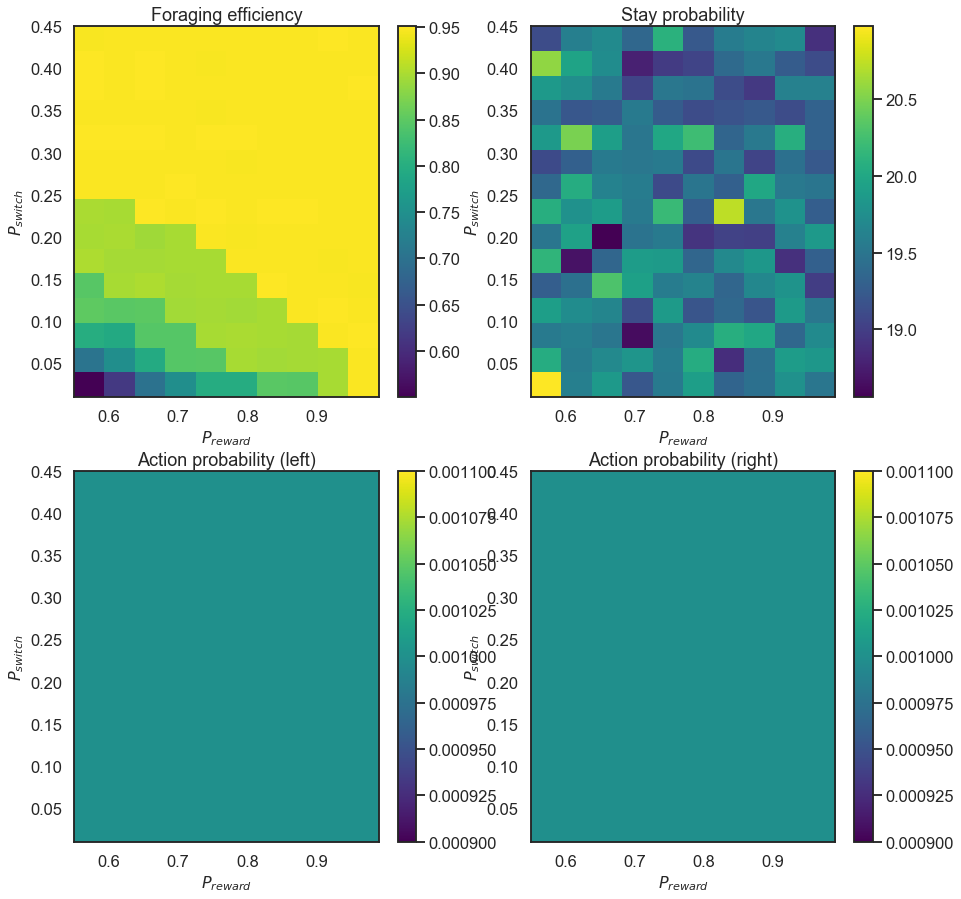

In [326]:
# Plot of foraging efficiency
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.imshow(efflist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)])
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Foraging efficiency')


# Plot of transition probability
plt.subplot(222)
plt.imshow(1 / (1-T11lst), aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)],
           
          )
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Stay probability')

plt.subplot(223)
plt.imshow(1-np.maximum(E1lst, E2lst), aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)])
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Action probability (left)')


plt.subplot(224)
plt.imshow(np.minimum(E1lst, E2lst), aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)])
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Action probability (right)')


In [102]:
efflist.max()

0.950990099009901

Text(0.5, 1.0, 'Left slope')

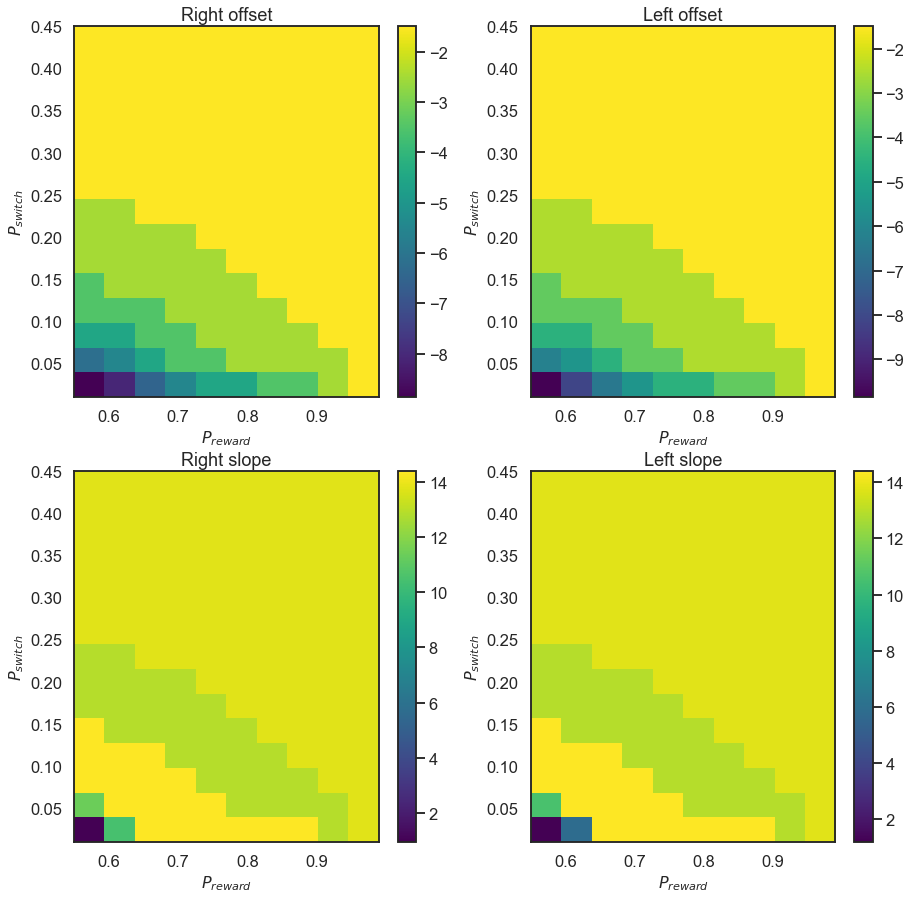

In [327]:
# Plot of foraging efficiency
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.imshow(PRoffsetlist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)],
          )
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Right offset')


# Plot of transition probability
plt.subplot(222)
plt.imshow(PLoffsetlist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)],
           
          )
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Left offset')

plt.subplot(223)
plt.imshow(PRslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)],
          )
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Right slope')


plt.subplot(224)
plt.imshow(-PLslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)],
          )
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Left slope')


In [289]:
pL

array([ 7.78741720e-05, -1.47980733e+04])

In [287]:
PRoffsetlist

array([[-8.90171777e+00, -8.22103211e+00, -6.53574344e+00,
        -5.50027606e+00, -4.72808113e+00],
       [-6.30044724e+00, -5.53596862e+00, -4.61178682e+00,
        -3.50029730e+00, -3.59393870e+00],
       [-4.44380403e+00, -4.63800951e+00, -3.56482258e+00,
        -3.49967136e+00, -2.47171424e+00],
       [-3.63731716e+00, -1.15933183e+04, -3.56560414e+00,
        -2.41005723e+00, -2.55405796e+00],
       [-3.63615764e+00, -2.52990556e+00, -2.56473082e+00,
        -2.52217282e+00, -2.47327016e+00]])

In [360]:
def find_LR_transition_fit(world, agent, window):
    '''
    For a switching world, determines the agent transition functions,
    for left->right and right->left transitions
    window: how many trials after the transition do we want to keep for fitting?
    '''
    # Find where the block transitions happen
    side_history = np.array(world.rate_history)[:,0]
    blocktrans = np.where(np.diff(side_history) != 0)[0][:-1]

    # Get the choices around the transition
    choicelst = []
    for i in range(window):
        choicelst.append(np.array(agent.choice_history)[blocktrans + i])

    choicelst = np.array(choicelst)

    #print('choicemean = ', np.mean(choicelst[:,::2]), 'side=  ', world.side_history[0][0])
    pRight, pLeft = fit_sigmoidal(choicelst, first_side=world.side_history[0][0])
    return (pRight, pLeft)
    

def fit_sigmoidal(choicelst, first_side):
    '''
    Fit a sigmoidal to the average choice data
    first_side: first side that is rewarded, i.e. world.side_history[0][0]
    '''
    #print('choicemean = ', np.mean(choicelst[:,::2]), 'side=  ', first_side)
    if first_side == 0:
        #print('left')
        leftAverage = np.mean(choicelst[:,::2], axis=1)
        rightAverage = np.mean(choicelst[:,1::2], axis=1)
    else:
        #print('right')
        rightAverage = np.mean(choicelst[:,::2], axis=1)
        leftAverage = np.mean(choicelst[:,1::2], axis=1)

    offsets = np.arange(len(leftAverage))

    # Fit right transitions
    funR = lambda x: errorsigmoid(x, offsets, rightAverage)
    paramsRight = scipy.optimize.minimize(funR, [1,1])
    pRight = paramsRight.x
    
    funL = lambda x: errorsigmoid(x, offsets, leftAverage)
    paramsLeft = scipy.optimize.minimize(funL, [1,1])
    pLeft = paramsLeft.x
    
    return pRight, pLeft

In [95]:
# Find where the block transitions happen
side_history = np.array(world.rate)[:,0]
blocktrans = np.where(np.diff(side_history))[0]

# Get the choices around the transition
choicelst = []
for i in range(10):
    choicelst.append(np.array(agent.choice_history)[blocktrans + i])
    
choicelst = np.array(choicelst)

# Fit a sigmoidal
if world.side_history[0][0] == 1:
    leftAverage = np.mean(choicelst[:,::2], axis=1)
    rightAverage = np.mean(choicelst[:,1::2], axis=1)
else:
    rightAverage = np.mean(choicelst[:,::2], axis=1)
    leftAverage = np.mean(choicelst[:,1::2], axis=1)

offsets = np.arange(len(leftAverage))

fun = lambda x: errorsigmoid(x, offsets, rightAverage)
paramsRight = scipy.optimize.minimize(fun, [1,1])

pRight = paramsRight.x


# For visualization of fit
# preds = 1 / (1 + np.exp(-p[0] * (offsets + p[1])))
# plt.plot(offsets, preds)
# plt.plot(offsets, rightAverage, '.')

ValueError: Expected 2D array, got 1D array instead:
array=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [359]:
np.array(world.rate_history)[:,0]

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
fun = lambda x: errorsigmoid(x, offsets, rightAverage)
params = scipy.optimize.minimize(fun, [1,1])

p = params.x
preds = 1 / (1 + np.exp(-p[0] * (offsets + p[1])))
plt.plot(offsets, preds)
plt.plot(offsets, rightAverage, '.')

In [103]:
rlow = 0
rhigh = 1
nblocks = 10
prew = 0.7
psw = 0.02
ntrials_per_block = [15, 25]
world = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = EGreedyInferenceBasedAgent(prew=prew, pswitch=psw, eps=0.1)
exp = Experiment(agent, world)
exp.run();  

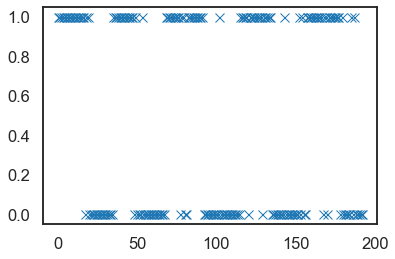

In [106]:
plt.plot(agent.choice_history[:200], 'x')
#plt.plot(agent.outcome_history[:50], '.')

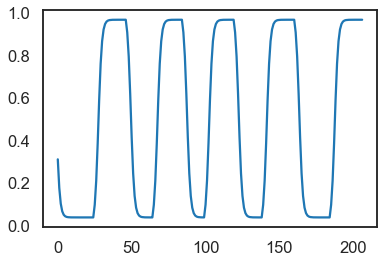

In [85]:
plt.plot(agent.p0_history)